# Train Model to Play DTTS

## Gym Environment

In [10]:
import random

import gym
import requests
import numpy as np
# import gymnasium as gym

class DttsSimulator:
    def __init__(self):
        self.flyVelocity = -20
        self.velocityX = 12
        self.gravity = 54
        self.initialSpikeCount = 3
        self.addSpikePer = 7
        self.scoreSpeedAdd = 0.008
        charSize = 1.2 * 2.4
        self.charTopBound = 1.5
        self.charBottomBound = 27.5
        self.charLeftBound = charSize / 2
        self.charRightBound = 20 - charSize / 2
        self.pineLeftBound = 4.8
        self.pineRightBound = 20-4.8
        
    def start(self):
        self.velocityY = self.flyVelocity
        self.charDir = 1
        self.playing = True
        self.charX = 10
        self.charY = 14.5
        self.charDir = 1
        self.spikeCount = self.initialSpikeCount
        self.score = 0
        self.speed = 1
        self.pinePos = None
        self.pineDir = None
        self.hasSpike = [False] * 12

    def touchedSpike(self):
        for i in range(12):
            if self.hasSpike[i] and self.charY > i*2.4 + 0.1 and self.charY < i*2.4 + 2.5:
                self.playing = False
                return True
        return False
    def addSpike(self):
        self.hasSpike = [False] * 12
        for i in random.sample(list(range(12)), self.spikeCount):
            self.hasSpike[i] = True
    def addPine(self, d):
        self.pineDir = d
        self.pinePos = random.randint(1, 10)
    def touchedPine(self):
        if self.pineDir is None or self.pinePos is None:
            return False
        if ((self.pineDir < 0 and self.charX < self.pineLeftBound) or
            (self.pineDir > 0 and self.charX > self.pineRightBound)):
            if self.charY > self.pinePos*2.4+0.1 and self.charY < self.pinePos*2.4+2.5:
                return True
        return False

    def update(self, action):
        if action == 1:
            self.velocityY = self.flyVelocity
        real_dt_ms = 50
        dt = real_dt_ms / 1000 * self.speed
        self.charX += self.velocityX * dt * self.charDir
        self.charY += self.velocityY * dt + self.gravity * dt * dt / 2
        self.velocityY += self.gravity * dt

        scored, pined = False, False
        if self.charX >= self.charRightBound:
            self.charX = self.charRightBound*2 - self.charX
            if not self.touchedSpike():
                self.charDir *= -1
                self.score += 1
                scored = True
                self.addSpike()
                if self.score % self.addSpikePer == 0 and self.spikeCount < 11:
                    self.spikeCount += 1
                if self.pineDir is None:
                    self.addPine(-1)
                self.speed += self.scoreSpeedAdd
        elif self.charX <= self.charLeftBound:
            self.charX = self.charLeftBound*2 - self.charX
            if not self.touchedSpike():
                self.charDir *= -1
                self.score += 1
                scored = True
                self.addSpike()
                if self.score % self.addSpikePer == 0 and self.spikeCount < 11:
                    self.spikeCount += 1
                self.speed += self.scoreSpeedAdd

        if self.touchedPine():
            pined = True
            self.addPine(-self.pineDir)
        if self.charY <= self.charTopBound:
            self.charY = self.charTopBound
            self.playing = False
        elif self.charY >= self.charBottomBound:
            self.charY = self.charBottomBound
            self.playing = False
        return scored, pined

    def state(self):
        def scale(value, min_value, max_value):
            return (value - min_value) / (max_value - min_value) * 2 - 1
        res = [
            scale(self.charX, self.charLeftBound, self.charRightBound),
            scale(self.charY, self.charTopBound, self.charBottomBound),
            self.charDir,
            scale(self.velocityY, self.flyVelocity, self.gravity),
            scale(self.pinePos or 0, 0, 10),
            self.pineDir or 0
        ]
        for i in self.hasSpike:
            res.append(1 if i else -1)
        return np.array(res)

class DttsEnv(gym.Env):
    def __init__(self, env_config={}):
        self.observation_space = gym.spaces.Box(-1, 1, shape=(18,))
        # self.action_space = gym.spaces.Discrete(3)  # BUG!
        self.action_space = gym.spaces.Discrete(2)

        env_config = {**{
            "alive_reward": 0,
            "pine_reward": 1,
            "score_reward": 5,
            "spike_penalty": 20,
        }, **env_config}
        self.alive_reward = env_config["alive_reward"]
        self.pine_reward = env_config["pine_reward"]
        self.score_reward = env_config["score_reward"]
        self.spike_penalty = env_config["spike_penalty"]

        self.dtts = DttsSimulator()
        self.dtts.start()

    def reset(self):
        self.dtts = DttsSimulator()
        self.dtts.start()
        return self.dtts.state()

    def step(self, action):
        if not self.dtts.playing:
            self.dtts.start()
        scored, pined = self.dtts.update(action)
        state = self.dtts.state()
        terminal = not self.dtts.playing
        reward = sum([
            0 if terminal else self.alive_reward,
            int(pined) * self.pine_reward,
            int(scored) * self.score_reward,
            -self.spike_penalty if terminal else 0,
        ])
        return state, reward, terminal, {}


## Selenium

In [3]:
from selenium import webdriver

# from selenium.webdriver.firefox.service import Service as FirefoxService
# from webdriver_manager.firefox import GeckoDriverManager

# from selenium.webdriver.chrome.service import Service as ChromeService
# from webdriver_manager.chrome import ChromeDriverManager

from selenium.webdriver.edge.service import Service as EdgeService
from webdriver_manager.microsoft import EdgeChromiumDriverManager

# driver = webdriver.Firefox(service=FirefoxService(GeckoDriverManager().install()))
# driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()))
driver = webdriver.Edge(service=EdgeService(EdgeChromiumDriverManager().install()))

driver.get(f"file:///C:/Users/Kirk/Documents/Project/Python/dtts_ai/dtts.html")


[WDM] - Downloading: 100%|██████████| 8.85M/8.85M [01:33<00:00, 99.2kB/s]


In [24]:
driver.execute_script("return getStatus()")


{'gameStatus': {'charDir': None,
  'charX': None,
  'charY': None,
  'hasSpike': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'pineDir': 0,
  'pinePos': 0,
  'velocityY': None},
 'pineCount': 0,
 'playing': False,
 'score': None}

## Evostra

### Evostra Callbacks

In [3]:
import os
import csv
import pickle
import multiprocessing

from tqdm.notebook import tqdm
from evostra import EvolutionStrategy


class EvolutionStrategyWithCallbacks(EvolutionStrategy):
    def __init__(
        self,
        *args,
        val_reward_func=None,
        population_progbar=False,
        callbacks=[],
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.val_reward_func = val_reward_func
        self.population_progbar = population_progbar
        self.callbacks = callbacks

    def run(self, iterations, initial_iteration=0):
        pool = multiprocessing.Pool(self.num_threads) if self.num_threads > 1 else None
        iteration = initial_iteration
        self.iterations = iterations
        self.training = True
        history = dict(reward=[], lr=[])
        if self.val_reward_func:
            history["val_reward"] = []
        while iteration < iterations and self.training:
            iteration += 1
            population = self._get_population()
            if self.population_progbar:
                population = tqdm(population, leave=False)
            rewards = self._get_rewards(pool, population)

            self._update_weights(rewards, population)

            current_iter_reward = self.get_reward(self.weights)
            history["reward"].append(current_iter_reward)
            history["lr"].append(self.learning_rate)
            if self.val_reward_func:
                current_iter_val_reward = self.val_reward_func(self.weights)
                history["val_reward"].append(current_iter_val_reward)
            else:
                current_iter_val_reward = None
            for cb in self.callbacks:
                cb(self, iteration, current_iter_reward, current_iter_val_reward)
        if pool is not None:
            pool.close()
            pool.join()
        return history


class ProgbarLogger:
    def __init__(self, print_new_line=False):
        self.print_new_line = print_new_line
        self.pbar = None

    def __call__(self, es, it, reward, val_reward):
        if self.pbar is None:
            self.pbar = tqdm(total=es.iterations)
            self.pbar.n = it - 1
        desc = f"Iter {it}/{es.iterations} reward: {reward:.6f}"
        if val_reward is not None:
            desc += f" val_reward: {val_reward:.6f}"
        self.pbar.desc = desc
        self.pbar.update()
        if self.print_new_line:
            print()


class EarlyStopping:
    def __init__(self, monitor_val=True, patience=0, verbose=0):
        self.monitor_val = monitor_val
        self.patience = patience
        self.verbose = verbose
        self.best_it, self.best_reward = 0, float("-inf")

    def __call__(self, es, it, reward, val_reward):
        if self.monitor_val:
            if val_reward is None:
                raise ValueError("val_reward is None. Did you pass val_reward_func?")
            r = val_reward
        else:
            r = reward
        if r > self.best_reward:
            self.best_it, self.best_reward = it, r
        if it - self.best_it >= self.patience:
            if self.verbose:
                reward_type = "val_reward" if self.monitor_val else "reward"
                print(
                    f"Earlystopping: iter {it}. {reward_type} {r}",
                    f"didn't increase from iter {self.best_it}. {self.best_reward}",
                )
            es.training = False


class ModelCheckpoint:
    def __init__(self, filepath, monitor_val=True, verbose=0, save_best_only=False):
        self.filepath = filepath
        self.monitor_val = monitor_val
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.best_reward = float("-inf")

    def __call__(self, es, it, reward, val_reward):
        if self.save_best_only:
            if self.monitor_val:
                if val_reward is None:
                    raise ValueError(
                        "val_reward is None. Did you pass val_reward_func?"
                    )
                r = val_reward
            else:
                r = reward
            if r > self.best_reward:
                if self.verbose:
                    reward_type = "val_reward" if self.monitor_val else "reward"
                    print(
                        f"{reward_type} increase from {self.best_reward} to {r}",
                        end=" ",
                    )
                self.best_reward = r
            else:
                return
        format_dict = {"iter": it, "reward": reward}
        if val_reward is not None:
            format_dict["val_reward"] = val_reward
        # print(self.filepath, format_dict)
        fpath = self.filepath.format(**format_dict)
        if self.verbose:
            print("Saving ES to", fpath)
        fdir = os.path.split(fpath)[0]
        if not os.path.exists(fdir):
            os.mkdir(fdir)
        with open(fpath, "wb") as file:
            # pickle.dump(es.weights, file)
            all_data = {
                "weights": es.weights,
                "population_size": es.POPULATION_SIZE,
                "sigma": es.SIGMA,
                "learning_rate": es.learning_rate,
                "decay": es.decay,
                "num_threads": es.num_threads,
            }
            pickle.dump(all_data, file)


class CSVLogger:
    def __init__(self, filename, separator=","):
        self.filename = filename
        self.separator = separator

    def __call__(self, es, it, reward, val_reward):
        try:
            open(self.filename).close()
        except FileNotFoundError:
            header = ["iter", "reward", "lr"]
            if val_reward is not None:
                header.append("val_reward")
            with open(self.filename, "w", newline="", encoding="utf-8-sig") as file:
                writer = csv.writer(file, delimiter=self.separator)
                writer.writerow(header)
        data = [it, reward, es.learning_rate]
        if val_reward is not None:
            data.append(val_reward)
        with open(self.filename, "a", newline="", encoding="utf-8-sig") as file:
            writer = csv.writer(file, delimiter=self.separator)
            writer.writerow(data)


### Model

#### MLP1 in18 dense32x2

In [46]:
import keras
from keras import layers as L


class MLP1:
    def __init__(self):
        self.name = "mlp_input18_dense32relu_dense32relu_dense1sigmoid"
        self.model = keras.Sequential(
            [
                L.Input(18),
                L.Dense(32, activation="relu"),
                L.Dense(32, activation="relu"),
                L.Dense(1, activation="sigmoid"),
            ],
            name=self.name,
        )
        self.model.summary()
        print(self.model.input_shape, self.model.output_shape)
        self.model.compile()

    def get_weights(self, *args, **kwargs):
        return self.model.get_weights(*args, **kwargs)

    def set_weights(self, *args, **kwargs):
        return self.model.set_weights(*args, **kwargs)

    def predict(self, data, *args, **kwargs):
        return self.model.predict(data, *args, **kwargs)[:, 0]


model = MLP1()


Model: "mlp_input18_dense32relu_dense32relu_dense1sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 32)                608       
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,697
Trainable params: 1,697
Non-trainable params: 0
_________________________________________________________________
(None, 18) (None, 1)


#### MLP2 in7 dense16x2

In [42]:
import keras
from keras import layers as L


class MLP2:
    def __init__(self):
        self.name = "mlp_input7_dense16relu_dense16relu_dense1sigmoid"
        self.model = keras.Sequential(
            [
                L.Input(7),
                L.Dense(16, activation="relu"),
                L.Dense(16, activation="relu"),
                L.Dense(1, activation="sigmoid"),
            ],
            name=self.name,
        )
        self.model.summary()
        print(self.model.input_shape, self.model.output_shape)
        self.model.compile()

    def get_weights(self, *args, **kwargs):
        return self.model.get_weights(*args, **kwargs)

    def set_weights(self, *args, **kwargs):
        return self.model.set_weights(*args, **kwargs)

    def predict(self, data, *args, **kwargs):
        return self.model.predict(data, *args, **kwargs)[:, 0]


model = MLP2()


Model: "mlp_input7_dense16relu_dense16relu_dense1sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 16)                128       
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________
(None, 7) (None, 1)


#### MLP3 in7 dense32x2

In [44]:
import keras
from keras import layers as L


class MLP3:
    def __init__(self):
        self.name = "mlp_input7_dense32relu_dense32relu_dense1sigmoid"
        self.model = keras.Sequential(
            [
                L.Input(7),
                L.Dense(32, activation="relu"),
                L.Dense(32, activation="relu"),
                L.Dense(1, activation="sigmoid"),
            ],
            name=self.name,
        )
        self.model.summary()
        print(self.model.input_shape, self.model.output_shape)
        self.model.compile()

    def get_weights(self, *args, **kwargs):
        return self.model.get_weights(*args, **kwargs)

    def set_weights(self, *args, **kwargs):
        return self.model.set_weights(*args, **kwargs)

    def predict(self, data, *args, **kwargs):
        return self.model.predict(data, *args, **kwargs)[:, 0]


model = MLP3()


Model: "mlp_input7_dense32relu_dense32relu_dense1sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                256       
                                                                 
 dense_31 (Dense)            (None, 32)                1056      
                                                                 
 dense_32 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________
(None, 7) (None, 1)


#### MLP4 in18 dense64x3

In [2]:
import keras
from keras import layers as L


class MLP4:
    def __init__(self):
        self.name = "mlp_input18_dense64relu_dense64relu_dense64relu_dense1sigmoid"
        self.model = keras.Sequential(
            [
                L.Input(18),
                L.Dense(64, activation="relu"),
                L.Dense(64, activation="relu"),
                L.Dense(64, activation="relu"),
                L.Dense(1, activation="sigmoid"),
            ],
            name=self.name,
        )
        self.model.summary()
        print(self.model.input_shape, self.model.output_shape)
        self.model.compile()

    def get_weights(self, *args, **kwargs):
        return self.model.get_weights(*args, **kwargs)

    def set_weights(self, *args, **kwargs):
        return self.model.set_weights(*args, **kwargs)

    def predict(self, data, *args, **kwargs):
        return self.model.predict(data, *args, **kwargs)[:, 0]


model = MLP4()


Model: "mlp_input18_dense64relu_dense64relu_dense64relu_dense1sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9,601
Trainable params: 9,601
Non-trainable params: 0
_________________________________________________________________
(None, 18) (None, 1)


#### MLP5 in18 dense64x2

In [13]:
import keras
from keras import layers as L

model = keras.Sequential(
    [
        L.Input(18),
        L.Dense(64, activation="tanh"),
        L.Dense(64, activation="tanh"),
        L.Dense(1, activation="sigmoid"),
    ],
    name="mlp_in18_dense64tanh2_dense1sigmoid",
)
model.compile()
model.summary()
print(model.input_shape, model.output_shape)


Model: "mlp_in18_dense64tanh2_dense1sigmoid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                1216      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________
(None, 18) (None, 1)


#### Wrap Model

In [36]:
import keras
from keras import layers as L


class WrapModel:
    def __init__(self, model):
        self.name = "evostra_" + model.name
        self.model = model
        self.model.summary()
        print(self.model.input_shape, self.model.output_shape)
        self.model.compile()

    def get_weights(self, *args, **kwargs):
        return self.model.get_weights(*args, **kwargs)

    def set_weights(self, *args, **kwargs):
        return self.model.set_weights(*args, **kwargs)

    def predict(self, data, *args, **kwargs):
        # return self.model.predict(data, *args, **kwargs)[:, 0]
        return self.model.predict(data, *args, **kwargs)[:, 1]
        # return np.argmax(self.model.predict(data, *args, **kwargs), axis=-1)


model = WrapModel(model)


Model: "mlp_input18_dense64relu3x_dense2softmax"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 64)                1216      
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 2)                 130       
                                                                 
Total params: 9,666
Trainable params: 9,666
Non-trainable params: 0
_________________________________________________________________
(None, 18) (None, 2)


### Train

In [ ]:
import os
import time
import pickle
import random

import requests
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt


def get_status():
    return requests.get("http://localhost:9775/status").json()


def do_action():
    requests.get("http://localhost:9775/do")


def preprocess_data(game_status):  # v0 18 values hasSpike
    res = [
        game_status[i] for i in "charX charY charDir velocityY pinePos pineDir".split()
    ]
    res += game_status["hasSpike"]
    return np.array([res]).astype(float)


def preprocess_data_v1(game_status):  # v1 7 values closestSafePos
    res = [
        game_status[i]
        for i in "charX charY charDir velocityY pinePos pineDir closestSafePos".split()
    ]
    return np.array([res]).astype(float)


class GetReward:
    def __init__(self, model, pbar=False):
        self.model = model
        self.pbar = pbar

    def __call__(self, weights):
        model = self.model
        pbar = self.pbar

        model.set_weights(weights)

        before_pine_count = get_status()["pineCount"]
        do_action()
        time.sleep(1)
        do_action()
        # time.sleep(0.1)
        # count = 0
        while True:
            stat = get_status()
            if not stat["playing"]:
                break
            # count += 1
            inp = preprocess_data(stat["gameStatus"])
            if model.predict(inp)[0] > 0.5:
                do_action()
                time.sleep(0.05)
        # print("count:", count)
        stat = get_status()
        score = stat["score"]
        pines = stat["pineCount"] - before_pine_count
        reward = score * 2 + pines
        # print("score pines:", score, pines)
        return reward


model_save_dir = f"model/{model.name}/"
model_save_path = model_save_dir + "model_{iter:03d}_{reward:.4f}.pkl"
csv_log_path = f"log/train.{model.name}.log.csv"

get_reward_func = GetReward(model)  # , pbar=True)
callbacks = [
    # ProgbarLogger(print_new_line=False),
    ProgbarLogger(print_new_line=True),
    EarlyStopping(patience=100, verbose=1, monitor_val=False),  # 20  # 40
    ModelCheckpoint(model_save_path),  # , verbose=1),
    CSVLogger(csv_log_path),
]

if os.path.isdir(model_save_dir):
    model_fname = sorted(os.listdir(model_save_dir))[-1]
else:
    model_fname = None
if model_fname:
    model_fpath = model_save_dir + model_fname
    print("Loading model from:", model_fpath)
    with open(model_fpath, "rb") as file:
        es_dict = pickle.load(file)
    # print("es dict:", es_dict)
    initial_iteration = int(model_fname.split("_")[1])
    es = EvolutionStrategyWithCallbacks(
        get_reward_func=get_reward_func,
        callbacks=callbacks,
        **es_dict,
    )
else:
    initial_iteration = 0
    es = EvolutionStrategyWithCallbacks(
        model.get_weights(),
        get_reward_func,
        population_size=20,
        sigma=0.1,
        learning_rate=0.03,
        decay=0.995,
        num_threads=1,
        callbacks=callbacks,
    )
print("initial_iteration:", initial_iteration)

# input("Press ENTER to start training...")
print("Running evostra...")
history = es.run(50, initial_iteration=initial_iteration)

for i in history.keys():
    h = np.array(history[i])
    # print(i, list(h))
    plt.plot(h, label=i)  # /max(h))
plt.legend()
plt.show()


In [6]:
get_status()


{'gameStatus': {'charDir': -1,
  'charX': 10.139839999999934,
  'charY': 28.125577347328033,
  'hasSpike': [0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0],
  'pineDir': -1,
  'pinePos': 5,
  'velocityY': 44.285056000000004},
 'pineCount': 119,
 'playing': False,
 'score': 17}

In [7]:
preprocess_data(get_status()["gameStatus"])


array([[10.13984   , 28.12557735, -1.        , 44.285056  ,  5.        ,
        -1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ]])

In [14]:
model.predict(preprocess_data(get_status()["gameStatus"]))[0] > 0.5


True

### Train Simulator Env

In [ ]:
model = keras.models.load_model("model/sim_v69_ddqn_m200k_b256_h3_d97_e0_vn01_s10k/tf")
model.summary()

In [ ]:
import os
import time
import pickle
import random

import requests
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

class GetReward:
    def __init__(self, model):
        self.model = model

    def __call__(self, weights):
        self.model.set_weights(weights)
        env = DttsEnv({
            "alive_reward": 1,
            "pine_reward": 5,
            "score_reward": 25,
            "spike_penalty": 100,
        })
        state = env.reset()
        total_reward = 0
        games = 5
        for i in range(games):
            one_game_reward = 100
            while True:
                # action = 1 if self.model.predict(state[np.newaxis, ...])[0][0] > 0.5 else 0
                pred = self.model.predict(state[np.newaxis, ...])[0]
                action = 1 if pred[1] > pred[0] else 0
                state, reward, terminal, info = env.step(action)
                one_game_reward += reward
                if terminal:
                    break
            total_reward += one_game_reward
        return total_reward / games

model_name = f"evostra_{model.name}_score1x5x25x100_tl"
model_save_dir = f"model/{model_name}/"
model_save_path = model_save_dir + "model_{iter:04d}_{reward:07.2f}.pkl"
csv_log_path = f"log/train.{model_name}.log.csv"

get_reward_func = GetReward(model)
callbacks = [
    ProgbarLogger(),
    EarlyStopping(patience=100, verbose=1, monitor_val=False),  # 20  # 40
    ModelCheckpoint(model_save_path),  # , verbose=1),
    CSVLogger(csv_log_path),
]

if os.path.isdir(model_save_dir):
    model_fname = sorted(os.listdir(model_save_dir))[-1]
else:
    model_fname = None
if model_fname:
    model_fpath = model_save_dir + model_fname
    print("Loading model from:", model_fpath)
    with open(model_fpath, "rb") as file:
        es_dict = pickle.load(file)
    # print("es dict:", es_dict)
    initial_iteration = int(model_fname.split("_")[1])
    es = EvolutionStrategyWithCallbacks(
        get_reward_func=get_reward_func,
        callbacks=callbacks,
        **es_dict,
    )
else:
    initial_iteration = 0
    es = EvolutionStrategyWithCallbacks(
        model.get_weights(),
        get_reward_func,
        population_size=20,
        sigma=0.1,
        learning_rate=0.03,
        decay=0.995,
        num_threads=1,
        # num_threads=4,
        callbacks=callbacks,
    )
print("initial_iteration:", initial_iteration)

# input("Press ENTER to start training...")
print("Running evostra...")
history = es.run(500, initial_iteration=initial_iteration)

for i in history.keys():
    h = np.array(history[i])
    # print(i, list(h))
    plt.plot(h, label=i)  # /max(h))
plt.legend()
plt.show()


## TensorForce

### Environment

In [2]:
import time

import requests
import numpy as np
from tensorforce.environments import Environment

# def get_status():
#     return requests.get("http://localhost:9775/status").json()
# def do_action():
#     requests.get("http://localhost:9775/do")


def get_status():
    return driver.execute_script("return getStatus()")


def do_action():
    driver.execute_script("doAction()")


def preprocess_data(game_status):  # v0 18 values hasSpike
    res = [
        game_status[i] for i in "charX charY charDir velocityY pinePos pineDir".split()
    ]
    res += game_status["hasSpike"]
    return np.array(res).astype(float)


# def preprocess_data_v1(game_status):  # v1 7 values closestSafePos
#     res = [game_status[i] for i in "charX charY charDir velocityY pinePos pineDir closestSafePos".split()]
#     return np.array(res).astype(float)
# def preprocess_data_cnn(game_status):  # v0 18 values hasSpike
#     res = [game_status[i] for i in "charX charY charDir velocityY pinePos pineDir".split()]
#     res += game_status["hasSpike"]
#     res = np.array(res).astype(float)
#     return {"1": res[:6], "2": res[6:][..., np.newaxis]}


class CustomEnvironment(Environment):
    def __init__(self):
        super().__init__()
        self.playing = False
        self.last_score = 0
        self.last_pines = 0

    def states(self):
        return dict(type="float", shape=(18,))
        # return dict(type='float', shape=(7,))
        # return {"1": dict(type='float', shape=(6,)), "2": dict(type='float', shape=(12, 1))}

    def actions(self):
        return dict(type="int", num_values=2)

    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; otherwise specify maximum number of training
    # timesteps via Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional additional steps to close environment
    def close(self):
        super().close()
        self.playing = False
        self.last_score = 0
        self.last_pines = 0

    def reset(self):
        self.playing = False
        self.last_score = 0
        self.last_pines = 0
        return preprocess_data(get_status()["gameStatus"])

    def execute(self, actions):
        if not self.playing:
            # print("start")
            self.playing = True
            self.last_score = 0
            self.last_pines = get_status()["pineCount"]
            do_action()
            # time.sleep(1)
            time.sleep(0.9)
            do_action()
        elif actions == 1:
            do_action()
        time.sleep(0.05)
        # time.sleep(0.005)
        stat = get_status()
        next_state = preprocess_data(stat["gameStatus"])
        terminal = not stat["playing"]
        reward = 0
        if stat["score"] > self.last_score:
            reward += (stat["score"] - self.last_score) * 5
            self.last_score = stat["score"]
        if stat["pineCount"] > self.last_pines:
            reward += stat["pineCount"] - self.last_pines
            self.last_pines = stat["pineCount"]
        if terminal:
            reward -= 20
        # print(next_state, terminal, reward)
        return next_state, terminal, reward


### Simulator

In [ ]:
import random

import requests
import numpy as np
from tensorforce.environments import Environment

class DttsSimulator:
    def __init__(self):
        self.flyVelocity = -20
        self.velocityX = 12
        self.gravity = 54
        self.initialSpikeCount = 3
        self.addSpikePer = 7
        self.scoreSpeedAdd = 0.008
        charSize = 1.2 * 2.4
        self.charTopBound = 1.5
        self.charBottomBound = 27.5
        self.charLeftBound = charSize / 2
        self.charRightBound = 20 - charSize / 2
        self.pineLeftBound = 4.8
        self.pineRightBound = 20-4.8
        
    def start(self):
        self.velocityY = self.flyVelocity
        self.charDir = 1
        self.playing = True
        self.charX = 10
        self.charY = 14.5
        self.charDir = 1
        self.spikeCount = self.initialSpikeCount
        self.score = 0
        self.speed = 1
        self.pinePos = None
        self.pineDir = None
        self.hasSpike = [False] * 12

    def touchedSpike(self):
        for i in range(12):
            if self.hasSpike[i] and self.charY > i*2.4 + 0.1 and self.charY < i*2.4 + 2.5:
                self.playing = False
                return True
        return False
    def addSpike(self):
        self.hasSpike = [False] * 12
        for i in random.sample(list(range(12)), self.spikeCount):
            self.hasSpike[i] = True
    def addPine(self, d):
        self.pineDir = d
        self.pinePos = random.randint(1, 10)
    def touchedPine(self):
        if self.pineDir is None or self.pinePos is None:
            return False
        if ((self.pineDir < 0 and self.charX < self.pineLeftBound) or
            (self.pineDir > 0 and self.charX > self.pineRightBound)):
            if self.charY > self.pinePos*2.4+0.1 and self.charY < self.pinePos*2.4+2.5:
                return True
        return False

    def update(self, action):
        if action == 1:
            self.velocityY = self.flyVelocity
        real_dt_ms = 50
        dt = real_dt_ms / 1000 * self.speed
        self.charX += self.velocityX * dt * self.charDir
        self.charY += self.velocityY * dt + self.gravity * dt * dt / 2;
        self.velocityY += self.gravity * dt

        scored, pined = False, False
        if self.charX >= self.charRightBound:
            self.charX = self.charRightBound*2 - self.charX
            if not self.touchedSpike():
                self.charDir *= -1
                self.score += 1
                scored = True
                self.addSpike()
                if self.score % self.addSpikePer == 0 and self.spikeCount < 11:
                    self.spikeCount += 1
                if self.pineDir is None:
                    self.addPine(-1)
                self.speed += self.scoreSpeedAdd
        elif self.charX <= self.charLeftBound:
            self.charX = self.charLeftBound*2 - self.charX
            if not self.touchedSpike():
                self.charDir *= -1
                self.score += 1
                scored = True
                self.addSpike()
                if self.score % self.addSpikePer == 0 and self.spikeCount < 11:
                    self.spikeCount += 1
                self.speed += self.scoreSpeedAdd

        if self.touchedPine():
            pined = True
            self.addPine(-self.pineDir)
        if self.charY <= self.charTopBound:
            self.charY = self.charTopBound
            self.playing = False
        elif self.charY >= self.charBottomBound:
            self.charY = self.charBottomBound
            self.playing = False
        return scored, pined

    def state(self):
        def scale(value, min_value, max_value):
            return (value - min_value) / (max_value - min_value) * 2 - 1
        res = [
            scale(self.charX, self.charLeftBound, self.charRightBound),
            scale(self.charY, self.charTopBound, self.charBottomBound),
            self.charDir,
            scale(self.velocityY, self.flyVelocity, self.gravity),
            scale(self.pinePos or 0, 0, 10),
            self.pineDir or 0
        ]
        for i in self.hasSpike:
            res.append(1 if i else -1)
        return np.array(res)

class CustomEnvironment(Environment):

    def __init__(self):
        super().__init__()
        self.dtts = DttsSimulator()
        self.dtts.start()

    def states(self):
        return dict(type='float', shape=(18,))
        # return dict(type='float', shape=(7,))
        # return {"1": dict(type='float', shape=(6,)), "2": dict(type='float', shape=(12, 1))}

    def actions(self):
        return dict(type='int', num_values=2)

    # Optional: should only be defined if environment has a natural fixed
    # maximum episode length; otherwise specify maximum number of training
    # timesteps via Environment.create(..., max_episode_timesteps=???)
    def max_episode_timesteps(self):
        return super().max_episode_timesteps()

    # Optional additional steps to close environment
    def close(self):
        super().close()
        self.dtts = DttsSimulator()
        self.dtts.start()

    def reset(self):
        self.dtts = DttsSimulator()
        self.dtts.start()
        return self.dtts.state()

    def execute(self, actions):
        if not self.dtts.playing:
            self.dtts.start()
        scored, pined = self.dtts.update(actions)
        state = self.dtts.state()
        terminal = not self.dtts.playing
        reward = int(scored) * 5 + int(pined) - (20 if terminal else 0)
        return state, terminal, reward


### Train

In [3]:
import csv

from tqdm.notebook import tqdm
from tensorforce.agents import Agent
from tensorforce.execution import Runner
from tensorforce.core.networks import AutoNetwork

train_env = Environment.create(environment=CustomEnvironment())

# saver_config = dict(frequency=5, unit="episodes", max_checkpoints=200)
saver_config = dict(frequency=10, unit="episodes", max_checkpoints=200)
summarizer_config = dict(directory="log/tensorforce_tensorboard")


class ProgbarLogger:
    def __init__(self, total, print_new_line=False):
        self.print_new_line = print_new_line
        self.pbar = tqdm(total=total)

    def __call__(self, runner, parallel_idx):
        self.pbar.n = runner.episodes - 1
        desc = f"Iter {runner.episodes}/{runner.num_episodes} return: {runner.episode_return[0]}"
        self.pbar.desc = desc
        self.pbar.update()
        if self.print_new_line:
            print()


class CSVLogger:
    def __init__(self, filename, separator=","):
        self.filename = filename
        self.separator = separator

    def __call__(self, runner, parallel_idx):
        try:
            open(self.filename).close()
        except FileNotFoundError:
            header = ["episode", "return"]
            with open(self.filename, "w", newline="", encoding="utf-8-sig") as file:
                writer = csv.writer(file, delimiter=self.separator)
                writer.writerow(header)
        data = [runner.episodes, runner.episode_return[0]]
        with open(self.filename, "a", newline="", encoding="utf-8-sig") as file:
            writer = csv.writer(file, delimiter=self.separator)
            writer.writerow(data)


class Serialize:
    def __init__(self, functions):
        self.functions = functions

    def __call__(self, *args, **kwargs):
        for f in self.functions:
            f(*args, **kwargs)


# tensorforce
# agent = Agent.create(
#     agent='tensorforce', environment=train_env,
#     update=64,
#     optimizer=dict(optimizer='adam', learning_rate=1e-3),
#     objective='policy_gradient',
#     reward_estimation=dict(horizon=25, discount=0.97),
#     # optional
#     memory=1000,
#     exploration=0.1,
# )

# vpg/reinforce
# agent = Agent.create(
#     agent='vpg', environment=train_env,
#     max_episode_timesteps=25*40,
#     batch_size=25,
#     # optional
#     discount=0.97,
#     exploration=0.1,
# )

# ppo
# agent = Agent.create(
#     agent='ppo', environment=train_env,
#     batch_size=25,
#     # learning_rate=1e-3,
#     # max_episode_timesteps=25*40,
#     # optional
#     discount=0.97,
#     exploration=0.1,
# )

# trpo
# agent = Agent.create(
#     agent='trpo', environment=train_env,
#     max_episode_timesteps=25*40, batch_size=10
# )

# dqn
# agent = Agent.create(
#     agent='dqn', environment=train_env,
#     memory=100, batch_size=10
# )

# ddqn
# definitely working, just need more tuning
# i've seen it passed to level 10
# model_name = "ddqn_mem5k_bs25_h25_d97_e10"
# model_name = "ddqn_mem5k_bs25_h25_d97_e10_again"
# model_name = "ddqn_mem5k_bs25_h25_d97_e10_score1x5x20x"  # good
# model_name = "ddqn_mem5k_bs25_h25_d97_e10_score1x5x20x_again"
# model_name = "ddqn_inV2_mem5k_bs25_h25_d97_e10_score1x5x20x"  # good
# model_name = "ddqn_inV2_mem5k_bs25_h25_d97_e10_score1x5x20x_layers3"  # good 73m
# model_name = "ddqn_inV2_mem5k_bs250_h25_d97_e01_score1x5x20x"
# model_name = "ddqn_mem50k_bs250_h25_d97_e10_score1x5x20x"
# model_name = "ddqn_in7_mem5k_bs25_h25_d97_e10_score1x5x20x"
# model_name = "ddqn_in7_singleSafe_mem5k_bs25_h25_d97_e10_score1x5x20x"
# model_name = f"ddqn_keras_{model.name}_mem5k_bs25_h25_d97_e10_score1x5x20x"
# model_name = f"ddqn_keras_{model.name}_mem50k_bs25_h25_d97_e10_score1x5x20x"
# model_name = f"ddqn_keras_{model.name}_mem50k_bs250_h25_d97_e10exp_lr001exp_score1x5x20x"
# model_name = f"ddqn_keras_{model.name}_mem5k_bs25_h25_d97_e10exp_lr001exp_score1x5x20x"
# model_name = "ddqn_se_mem5k_bs25_h25_d97_e10_score1x5x20x"  # good
# model_name = "ddqn_se_mem5k_bs25_h25_d97_e10decay97_score1x5x20x"  # good 83.5m  # score:5.69/4.24
# model_name = "ddqn_se_mem50k_bs250_h25_d97_e10decay97_score1x5x20x_ep2k"  # good 3h5m  # score:4.43/5.05
# model_name = "ddqn_se_mem50k_bs250_h25_d97_e10decay97_upweight20_score1x5x20x"  # good 1h28m
model_name = "ddqn_se_mem5k_bs25_h25_d97_e10decay97_upweight20_score1x5x20x"
# model_name = "ddqn_se_mem500k_bs2500_h25_d97_e10decay97_upweight20_score1x5x20x"  # bad, bs too big
# model_name = "ddqn_se_mem5k_bs25_h25_d97_e10decay97_score1x5x20x_ep5k"
# model_name = "ddqn_se_mem16k_bs80_h80_d97_e10decay97_3layers_score1x5x20x"
# model_name = "ddqn_se_mem5k_bs25_h25_d97_e10decay97_3layers_score1x5x20x"
# model_name = "ddqn_se_mem5k_bs25_h25_d97_e10decay97_lrelu3layers_score1x5x20x"
# model_name = "ddqn_se_mem5k_bs250_h25_d97_e10decay97_lrelu3layers_score1x5x20x"
model_save_dir = f"model/{model_name}"
if os.path.exists(model_save_dir):
    agent = Agent.load(directory=model_save_dir)
    print("agent loaded")
else:
    agent = Agent.create(
        agent="ddqn",
        environment=train_env,
        saver=dict(directory=model_save_dir, **saver_config),
        summarizer=dict(filename=f"tb-{model_name}", **summarizer_config),
        # # required
        memory=5000,
        batch_size=25,
        # memory=50000,
        # batch_size=250,
        # memory=16000,
        # batch_size=80,
        # memory=500000,
        # batch_size=2500,  # too big
        # # optional
        horizon=25,
        # horizon=80,
        discount=0.97,
        target_update_weight=0.2,
        # exploration=0.1,
        # exploration=0.01,
        exploration=dict(
            type="exponential",
            unit="episodes",
            num_steps=1000,
            initial_value=0.1,
            decay_rate=0.97,
        ),
        # learning_rate=dict(type="exponential", unit="episodes", num_steps=1000, initial_value=1e-3, decay_rate=0.997),
        # network=AutoNetwork(depth=3),
        # network=[
        #     dict(name="dense0", type='dense', size=64, activation='tanh'),
        #     dict(name="dense1", type='dense', size=64, activation='tanh'),
        #     dict(name="dense2", type='dense', size=64, activation='tanh'),
        # ],
        # network=[
        #     dict(name="dense0", type='dense', size=64, activation='leaky-relu'),
        #     dict(name="dense1", type='dense', size=64, activation='leaky-relu'),
        #     dict(name="dense2", type='dense', size=64, activation='leaky-relu'),
        # ],
        # network=model,
    )

# dueling_dqn worth trying?
# agent = Agent.create(
#     agent='dueling_dqn', environment=train_env,
#     memory=100, batch_size=10
# )

# ac
# agent = Agent.create(
#     agent='ac', environment=train_env,
#     batch_size=10
# )

# a2c
# model_name = "a2c_bs25_h25_d97_e10_score1x5x20x"
# agent = Agent.create(
#     agent='a2c',
#     environment=train_env,
#     saver=dict(directory=f"model/{model_name}", **saver_config),
#     summarizer=dict(filename=f"tb-{model_name}", **summarizer_config),
#     batch_size=25,
#     # optional
#     horizon=25,
#     discount=0.97,
#     exploration=0.1,
# )

# print(agent.get_architecture())
runner = Runner(agent, environment=train_env)
num_episodes = 1000
# input("Press ENTER to run...")
time.sleep(5)
print("Start.")
runner.run(
    num_episodes=num_episodes,
    use_tqdm=False,
    callback=Serialize(
        [ProgbarLogger(num_episodes), CSVLogger(f"log/train.{model_name}.log.csv")]
    ),
)
# runner.close()

# hyperparam to try:
# memory bigger ?
# warm-up ?
# batch size ?
# model sync count / update freq ?
# lr smaller ?
# discount ?
# exploration ?


Start.


  0%|          | 0/1000 [00:00<?, ?it/s]

In [87]:
%tensorboard --logdir log/tensorforce_tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [4]:
import pandas as pd

df = pd.read_csv(f"log/train.{model_name}.log.csv")


In [8]:
df["return"].describe()


count    1000.000000
mean       -4.061000
std        12.472965
min       -15.000000
25%       -10.000000
50%        -9.000000
75%         0.000000
max        65.000000
Name: return, dtype: float64

<AxesSubplot:>

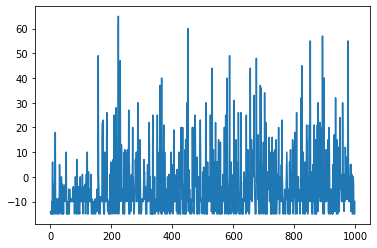

In [15]:
df["return"].plot()


<AxesSubplot:>

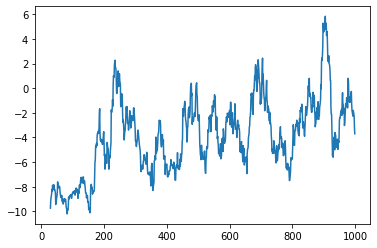

In [17]:
(df["return"].rolling(30).sum() / 30).plot()


### Run

In [6]:
# runner = Runner(agent, environments=[train_env], evaluation=True)
# runner.run(num_episodes=1)

# runner = Runner(agent, environment=train_env)
# runner.run(num_episodes=1, evaluation=True)

# state = preprocess_data(get_status()["gameStatus"])
# agent.act(state)

time.sleep(3)

for i in range(10):
    time.sleep(1)

    do_action()
    time.sleep(0.9)
    do_action()
    terminal = False
    while not terminal:
        time.sleep(0.05)
        stat = get_status()
        state = preprocess_data(stat["gameStatus"])
        terminal = not stat["playing"]
        act = agent.act(state, independent=True)
        # print(act, stat)
        if act == 1:
            do_action()


### Save

In [1]:
import keras
from keras import layers as L

model = keras.Sequential(
    [
        L.Input(18),
        L.Dense(64, activation="tanh"),
        L.Dense(64, activation="tanh"),
        L.Dense(2),
    ],
    name="mlp_input18_dense64tanh2x_dense2",
)
model.summary()
print(model.input_shape, model.output_shape)
print("weigths:", [i.shape for i in model.get_weights()])


Model: "mlp_input18_dense64tanh2x_dense2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 5,506
Trainable params: 5,506
Non-trainable params: 0
_________________________________________________________________
(None, 18) (None, 2)
weigths: [(18, 64), (64,), (64, 64), (64,), (64, 2), (2,)]


In [2]:
from tensorforce.agents import Agent

# model_name = "v09_ddqn_mem50k_bs25_h25_d97_e01"
# model_name = "v17_ddqn_m50k_b25_h25_d97_e01_sf40"
# model_name = "v30_ddqn_mem50k_bs25_h25_d97_e005_vn003"
# model_name = "sim_v58_ddqn_m50k_b32_h3_d97_e0_vn01"
# model_name = "sim_v69_ddqn_m200k_b256_h3_d97_e0_vn01_s10k"
# model_name = "sim_v82_ddqn_m200k_b256_h3_d97_e0_vn01_s10k_v69cont"
# model_name = "sim_v85_ddqn_m200k_b256_h3_d97_e0_vn01_lr00032_v69v82"
# model_name = "sim_v95_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_v69v82v85"
# model_name = "sim_v98_ddqn_m200k_b256_h3_d97_e0_vn01_lr0001_rdt20_v69v82v85"
# model_name = "sim2_v04_ddqn_m200k_b1k_h3_d97_e0_vn01_lr00005_v69v82v85v95"
# model_name = "sim2_v05_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_rdt20_v69v82v85v98"
model_name = "sim2_v08_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_rdt20_single_v69v82v85v98v05"
agent = Agent.load(directory=f"model/{model_name}")


In [3]:
# # convert to Keras SavedModel by building model then set weights because
# # agent.save(directory=f"model/tf-{model_name}", format='saved-model') would cause
# # AssertionError: Tried to export a function which references 'untracked' resource Tensor

import numpy as np

print(agent.get_architecture())
npz_path = agent.save(
    directory=f"model/{model_name}", format="numpy", append="episodes"
)
print(npz_path)
data = np.load(npz_path)
# print(data.files)

keys = [
    "policy/network/dense0/weights",
    "policy/network/dense0/bias",
    "policy/network/dense1/weights",
    "policy/network/dense1/bias",
    "policy/action_value/linear/weights",
    "policy/action_value/linear/bias",
]
model.set_weights([data[k] for k in keys])
model.save(f"model/{model_name}/tf")


Policy:
    Network:  
        Dense(name=dense0, size=64, bias=True, activation=tanh)
        Dense(name=dense1, size=64, bias=True, activation=tanh)Action-value:  Linear(name=action_value, size=2, bias=True)
Baseline:
    Network:  
        Dense(name=dense0, size=64, bias=True, activation=tanh)
        Dense(name=dense1, size=64, bias=True, activation=tanh)Action-value:  Linear(name=action_value, size=2, bias=True)
model/sim2_v08_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_rdt20_single_v69v82v85v98v05\agent-25400.npz


### Plot csv

In [8]:
%matplotlib widget


202 kaggle_log\train.new_v02_ddqn_m200k_b256_h3_d97_e0_vn01_s10k.log.csv
203 kaggle_log\train.new_v03_ddqn_m200k_b256_h3_d97_e0_vn01_s10k_rdt20.log.csv
156 kaggle_log\train.sim2_v06_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_rdt20_v69v82v85v98v05.log.csv
157 kaggle_log\train.sim2_v07_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_rdt20_pine_v69v82v85v98v05.log.csv
119 kaggle_log\train.sim_v69_ddqn_m200k_b256_h3_d97_e0_vn01_s10k.log.csv


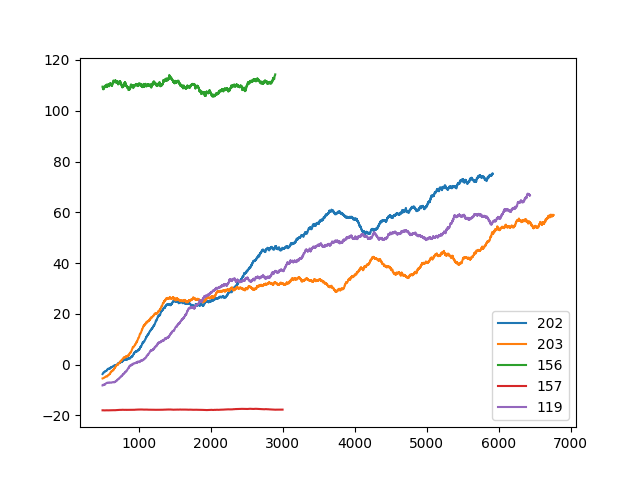

In [11]:
import os
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt

files = sorted(glob("kaggle_log/*.csv"))
# ma_window = 50
# ma_window = 200
ma_window = 500
# ma_window = 1000
# ma_window = 2000
plt.close()
for i, f in enumerate(files):
    df = pd.read_csv(f)
    df_ma = (df["return"].rolling(ma_window).sum() / ma_window).to_numpy()
    label = f[len("kaggle_log/train.") :]
    if label.startswith("sim_v"):
        label = int(label[len("sim_v") :][:2]) + 50
    elif label.startswith("sim2_v"):
        label = int(label[len("sim2_v") :][:2]) + 150
    elif label.startswith("ray_v"):
        label = int(label[len("ray_v") :][:2]) + 100
    elif label.startswith("new_v"):
        label = int(label[len("new_v") :][:2]) + 200
    elif label.startswith("v"):
        label = int(label[len("v") :][:2])
    # if label not in [9, 17] and label <= 20:
    # if label not in [9, 17, 30]:  # best per 10
    # if label not in [12, 17, 28, 30, 31]:  # best to try
    # if label not in [9, 13, 14, 15, 17, 28, 30, 58, 60, 64, 101, 108, 117, 119]:  # best
    # if label not in [9, 11, 12, 22, 23, 24]:  # compare e
    # if label not in [16, 17, 18, 25, 26]:  # e01, compare sf
    # if label not in [17, 27]:  # sf40, compare e
    # if label not in [19, 28]:  # vn01, compare e
    # if label not in [19, 29]:  # e01, compare vn
    # if label not in [29, 30]:  # vn003, compare e
    # if label not in [12, 30]:  # e005, compare vn
    # if label not in [22, 28]:  # e0, compare vn
    # if label > 10:
    # if label <= 10 or label > 20:
    # if label <= 20 or label > 30:
    # if label <= 30:
    # if label <= 111 or label >= 124:
    # if label not in [9, 17, 28, 30] and label <= 31:
    # if label not in [28, 30] and label < 50:
    # if label not in [117, 119]:
    # if label not in [117, 119] and label <= 125:
    # if label not in [117, 119, 131, 132] and label <= 132:
    # if label not in [117, 119, 131, 132, 133, 135, 136, 139]:
    # if label in [147] or label <= 147:
    # if label not in [141, 143, 144, 145, 148, 149]:
    # if label <= 150:
    if label not in [119, 202, 203, 156, 157]:
        continue
    print(label, f)
    plt.plot(df_ma, label=label)
plt.legend()
plt.show()

"""
kaggle_log\train.v09_ddqn_mem50k_bs25_h25_d97_e01.log.csv

kaggle_log\train.v03_ddqn_mem50k_bs250_h25_d97_e10decay97.log.csv
kaggle_log\train.v04_ddqn_mem50k_bs250_h25_d97_e10decay97_upweight20.log.csv

kaggle_log\train.v06_ddqn_mem50k_bs25_h25_d97_e10decay995_upweight20.log.csv
kaggle_log\train.v07_ddqn_mem50k_bs25_h25_d97_e10decay995.log.csv
kaggle_log\train.v08_ddqn_mem50k_bs25_h25_d97_e10.log.csv
kaggle_log\train.v10_ddqn_mem50k_bs25_h25_d97_e10dec995_lr001dec998.log.csv

kaggle_log\train.v01_ddqn_mem5k_bs25_h25_d97_e10.log.csv
kaggle_log\train.v02_ddqn_mem5k_bs25_h25_d97_e10decay97.log.csv
kaggle_log\train.v05_ddqn_mem5k_bs25_h25_d97_e10decay97_upweight20.log.csv

mem50k > mem5k
bs250 > bs25
e01 > e10 ~ e10decay
upweight100 ~ upweight20

to try:
mem 200k?
bs 1k?
e05 e02 e01 e005?

unknown:
target_sync_frequency (sf)
variable_noise (vn)

probably not:
update_frequency (uf)
start_updating (su)
learning_rate (lr)
discount (d)

v09_ddqn_mem50k_bs25_h25_d97_e01  (live test 50 times avg score:8.28, 30 times avg score: 8.47)
v11_ddqn_mem50k_bs25_h25_d97_e02
v12_ddqn_mem50k_bs25_h25_d97_e005
v13_ddqn_mem50k_bs250_h25_d97_e01
v14_ddqn_mem200k_bs250_h25_d97_e01
v15_ddqn_mem200k_bs1k_h25_d97_e01
v16_ddqn_mem50k_bs25_h25_d97_e01_sf10
v17_ddqn_mem50k_bs25_h25_d97_e01_sf40  (live test 50 times avg score:9.8, 30 times avg score: 8.9)
v18_ddqn_mem50k_bs25_h25_d97_e01_sf120
v19_ddqn_mem50k_bs25_h25_d97_e01_vn01
v20_ddqn_mem50k_bs25_h25_d97_e01_vn10
(when doing live test, keep browser in foreground is important)
(then what about training?)

e01 > e02
bs25 > bs250
mem50k ~ mem200k
vn01 > vn10
sf40 > sf10 > sf120

to try:
more different e
vn without e
smaller vn
more different sf

next to try:
exp decay exploration

v22_ddqn_m50k_bs25_h25_d97_e0
v23_ddqn_m50k_bs25_h25_d97_e002
v24_ddqn_m50k_bs25_h25_d97_e007
v25_ddqn_m50k_bs25_h25_d97_e01_sf60
v26_ddqn_m50k_bs25_h25_d97_e01_sf80
v27_ddqn_m50k_bs25_h25_d97_e005_sf40
v28_ddqn_mem50k_bs25_h25_d97_e0_vn01
v29_ddqn_mem50k_bs25_h25_d97_e01_vn003
v30_ddqn_mem50k_bs25_h25_d97_e005_vn003  (live test 30 times avg score: 8.9)
v31_ddqn_mem50k_bs25_h25_d97_e005_sf40_vn003

e0 > others
when e01, sf40 > others
when sf40, e01 > e005
when vn01, e0 > e01
when e01, vn01 > vn003
when vn003, e005 > e01
when e005, vn003 > vn0

(try not speed up when level up) (h d?)

decay:
lr bs d e
(dont decay the lr, increase the bs?)

v32_ddqn_m50k_b25_h25_d97_e02_sf40
v33_ddqn_m50k_b25_h25_d97_e0_vn02

v34_ddqn_m50k_b25_h25_d97_e01d9995_sf40
v35_ddqn_m50k_b25_h25_d97_e01_sf40_lr001d9995
v36_ddqn_m50k_b25_h25_d97_e01d9995_sf40_lr001d9995
# v37_ddqn_m50k_b25to250_h25_d97_e01_sf40
# v38_ddqn_m50k_b25_h25d99985_d97_e01_sf40

v39_ddqn_m50k_bs25_h25_d97_e0_vn01_lr001d9995
# v40_ddqn_m50k_bs25to250_h25_d97_e0_vn01
# v41_ddqn_m50k_bs25_h25d99985_d97_e0_vn01

v50_ddqn_m50k_b25_h25_d97_e01_sf40_nospeed
v51_ddqn_m50k_b25_h25_d97_e0_vn01_nospeed
v52_ddqn_m50k_b25_h25_d97_e005_vn003_nospeed
v53_ddqn_m50k_b25_h25_d97_e0_vn01_speed

sim_v28_ddqn_mem50k_bs25_h25_d97_e0_vn01  (live test 30 times avg score: 4.47)

arch: 3layers, 128neurons, 32neurons, 1layer256neurons
bs: 64
horizon: 32
discount: ?
regularization: l2_regularization=0.1?
lr: 1e-4?
auto tuner: tune.py?
random dt?

v54_ddqn_m50k_b25_h25_d97_e0_vn01_net64x3   9h8m   18
v55_ddqn_m50k_b25_h25_d97_e0_vn01_net128x2  11h15m 26
v56_ddqn_m50k_b25_h25_d97_e0_vn01_net32x2   10h40m 25.5
v57_ddqn_m50k_b25_h25_d97_e0_vn01_net256x1  11h41m 23.8
v58_ddqn_m50k_b25_h3_d97_e0_vn01            slow & stable   7h2m 19.4
v59_ddqn_m50k_b25_h25_d97_e0_vn01_l2reg10   slow & unstable 6h23m 0.6
v60_ddqn_m50k_b25_h25_d97_e0_vn01_lr0001    slow & stable   6h49m 8.9
v61_ddqn_m50k_b32_h3_d99_e0_vn50_lr0001_net256x1_sf500_start10k      poor
sim_v61_ddqn_m50k_b32_h3_d99_e0_vn50_lr0001_net256x1_sf500_start10k  poor
v1_ray_rainbow_tuned_example_pong           12h 43.6

v58_ddqn_m50k_b25_h3_d97_e0_vn01         7000ep 12h 39 quick & stable (good luck)
v60_ddqn_m50k_b25_h25_d97_e0_vn01_lr0001 7000ep 12h 19.5 slow & stable
v64_ddqn_m50k_b25_h25_d97_e0_vn01_l2reg01    11h12m 30 slow & stable
v65_ddqn_m50k_b32_h3_d99_e0_vn01_lr0001_net256x1_sf500_start10k  8h48m 13 slow but osc
sim_v58_ddqn_m50k_b32_h3_d97_e0_vn01     30kep 12h 48.5 5k~10k osc  (live test 30 times avg score: 10.5)

9, 13, 14, 15, 17, 28, 30, 58, 60, 64, 101, 108

m+ b+ lr- l2reg01
sim_v66_ddqn_m50k_b32_h3_d97_e0_vn01_s10k    12h 38
sim_v67_ddqn_m200k_b32_h3_d97_e0_vn01_s10k   12h 67
sim_v68_ddqn_m50k_b256_h3_d97_e0_vn01_s10k   12h 55.6
sim_v69_ddqn_m200k_b256_h3_d97_e0_vn01_s10k  12h 67.4  (live test 30 times avg score: 15.2, 5ms: 18.2, 0ms: 19.8)
sim_v70_ddqn_m50k_b32_h1_d97_e0_vn01_s10k    poor
sim_v71_ddqn_m50k_b32_h5_d97_e0_vn01_s10k    12h 45
sim_v72_ddqn_m50k_b32_h3_d97_e0_vn01_s10k_lr0001       12h 43.5
sim_v73_ddqn_m50k_b32_h3_d97_e0_vn01_s10k_lr0005d9997  12h 50.9
sim_v74_ddqn_m50k_b32_h3_d97_e0_vn01_s10k_l2reg01      poor
sim_v75_ddqn_m200k_b256_h3_d97_e0_vn01_s10k_l2reg01_lr0005d9997  poor

m200k > m50k
b256 slower than b32, not sure if more stable
h1 poor, h5 worse, not sure about h2 h4
lr0001 slow, still not stable
lr0005d9997 still slow & not stable
l2reg01 poor

to try:
m500k, m500k+b256, no s10k, h2, h4, env 5ms, continue training v67 v69
# sim_v67_ddqn_m500k_b32_h3_d97_e0_vn01_s10k
sim_v76_ddqn_m500k_b256_h3_d97_e0_vn01_s10k  slow?!
sim_v77_ddqn_m200k_b256_h3_d97_e0_vn01       okay, but not better
sim_v78_ddqn_m200k_b32_h2_d97_e0_vn01_s10k   okay, but worse than h4
sim_v79_ddqn_m200k_b32_h4_d97_e0_vn01_s10k   okay, but worse than h3
sim_v80_ddqn_m200k_b32_h3_d97_e0_vn01_s10k_env5ms   poor
sim_v81_ddqn_m200k_b32_h3_d97_e0_vn01_s10k_v67cont  72.5
sim_v82_ddqn_m200k_b256_h3_d97_e0_vn01_s10k_v69cont 85.5  (live test 30 times avg score: 15, 0ms: 21.5)

sim_v83_ddqn_m200k_b512_h3_d97_e0_vn01_v69v82          101.7
sim_v84_ddqn_m200k_b1k_h3_d97_e0_vn01_v69v82           down
sim_v85_ddqn_m200k_b256_h3_d97_e0_vn01_lr00032_v69v82  107  (live test 30 times 27ms: 21.9, 0ms: 20.5)
sim_v86_ddqn_m200k_b256_h3_d97_e0_vn01_lr0001_v69v82   102.5
sim_v87_ddqn_m200k_b256_h3_d99_e0_vn01_v69v82          poor
sim_v88_ddqn_m200k_b256_h3_d97_e0_vn01_sf500_v69v82    no
sim_v89_ddqn_m200k_b256_h3_d97_e0_vn01_sf40_v69v82     98.4
sim_v90_ddqn_m200k_b256_h3_d97_e0_vn01_nospeed_v69v82  no

b512 up osc
b1k down osc
lr00032 up osc
lr0001 up osc
d99 poor
sf500 no improve
sf40 up osc
133, 135, 136, 139
no speed no improve

sim_v91_ddqn_m200k_b256_h3_d97_e0_vn01_lr00032_v69v82v85          113
sim_v92_ddqn_m200k_b256_h3_d97_e0_vn01_lr0001_v69v82v85           down
sim_v93_ddqn_m200k_b256_h3_d97_e0_vn01_lr00005_v69v82v85          109
sim_v94_ddqn_m200k_b256_h3_d965_e0_vn01_lr0001_v69v82v85          111.5
sim_v95_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_v69v82v85           113.5 #3000  (live 30: 27ms: 27.4, 0ms: 26.4)
sim_v96_ddqn_m200k_b256_h3_d97_e0_vn01_lr0001_sf40_v69v82v85      103.8 slow up
sim_v97_ddqn_m200k_b256_h3_d97_e0_vn01_lr0001_single_v69v82v85    poor
sim_v98_ddqn_m200k_b256_h3_d97_e0_vn01_lr0001_rdt20_v69v82v85     106.5 slow up #2760  (27ms: 21.3, 0ms: 30.2)
sim_v99_ddqn_m200k_b256_h3_d97_e0_vn01_lr0001_speed112_v69v82v85  111.2

sim2_v01_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_v69v82v85v95        112.8  osc
sim2_v02_ddqn_m200k_b512_h3_d97_e0_vn01_lr00005_v69v82v85v95       113.5  osc
sim2_v03_ddqn_m200k_b1k_h3_d97_e0_vn01_lr0001_v69v82v85v95         111.5  osc
sim2_v04_ddqn_m200k_b1k_h3_d97_e0_vn01_lr00005_v69v82v85v95        116.4  first best, then down, osc #520 (25,31.7/28.4)
sim2_v05_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_rdt20_v69v82v85v98  113  up converge  #2580 (24.1,32.4)
new_v01_ddqn_m200k_b256_h3_d97_e0_vn01_s10k

normal, +-20ms, single, pine

10k-ep
new_v02_ddqn_m200k_b256_h3_d97_e0_vn01_s10k
new_v03_ddqn_m200k_b256_h3_d97_e0_vn01_s10k_rdt20
new_v04_ddqn_m200k_b256_h3_d97_e0_vn01_s10k_single
new_v05_ddqn_m200k_b256_h3_d97_e0_vn01_s10k_pine
sim2_v06_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_rdt20_v69v82v85v98v05
sim2_v07_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_rdt20_pine_v69v82v85v98v05
sim2_v08_ddqn_m200k_b512_h3_d97_e0_vn01_lr0001_rdt20_single_v69v82v85v98v05  4.5 #6620 (23.1,20.5)

"""
None


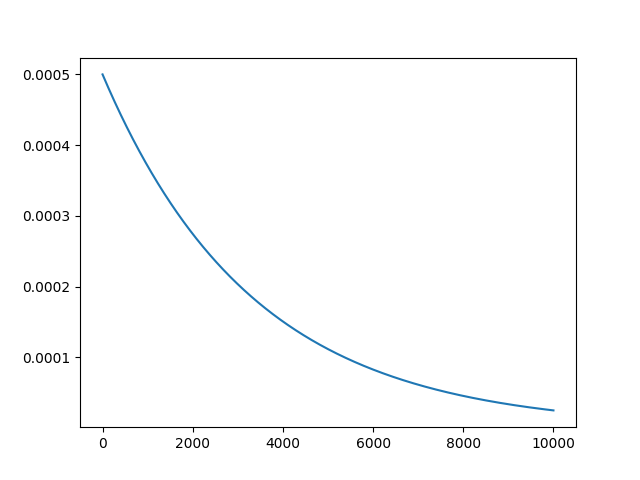

In [35]:
initial, decay, num = 0.0005, 0.9997, 10000
# initial, decay, num = 0.001, 0.9997, 10000
plt.close()
plt.plot([initial * (decay**i) if i<num else initial * (decay**num) for i in range(10000)])
plt.show()


## Supervised

### Data

In [8]:
import json

data_files = [
    "data_0_100episodes_1187rounds_20687steps.json",
    "data_1_100episodes_1344rounds_23147steps.json",
]

data = [[], []]
for i in data_files:
    with open(i) as file:
        new_data = json.load(file)
    data[0] += new_data[0]
    data[1] += new_data[1]

with open("data.json", "w") as file:
    json.dump(data, file)
print(len(data[0]))


43834


In [ ]:
import numpy as np
# np.array(data[0]).shape
# np.min(data[0])
# np.max(data[0])

value = np.min(data[0])
for i in range(len(data[0])):
    for j in range(len(data[0][0])):
        if data[0][i][j] == value:
            print(i, j)
# 3 velocityY -18.913088 50.038864
# -20 54

In [34]:
import json
import numpy as np

with open("data.json") as file:
    data_X, data_y = json.load(file)

count = [data_y.count(0), data_y.count(1)]
class_weight = {0: 1 / 2 / count[0] * len(data_y), 1: 1 / 2 / count[1] * len(data_y)}
data_X = np.array(data_X)
data_y = np.array([[[1, 0], [0, 1]][i] for i in data_y])
print(data_X.shape, data_y.shape, count, class_weight)
# 0 (20687, 18) (20687, 2) [18043, 2644] {0: 0.573269411960317, 1: 3.9120650529500756}
# 01 (43834, 18) (43834, 2) [38213, 5621] {0: 0.5735482689137205, 1: 3.8991282689912827}


(43834, 18) (43834, 2) [38213, 5621] {0: 0.5735482689137205, 1: 3.8991282689912827}


In [60]:
# to CNN input
data_X = (data_X[:, :6], data_X[:, 6:][..., np.newaxis])
print(data_X[0].shape, data_X[1].shape)


(20687, 6) (20687, 12, 1)


### Model

#### MLP

In [7]:
import keras
from keras import layers as L

model = keras.Sequential(
    [
        L.Input(18),
        L.Dense(64, activation="relu"),
        L.Dense(64, activation="relu"),
        # L.Dense(64, activation="relu"),
        L.Dense(2, activation="softmax"),
    ],
    name="mlp_input18_dense64relu2x_dense2softmax",
)
# ], name="mlp_input18_dense64relu3x_dense2softmax")
model.summary()
print(model.input_shape, model.output_shape)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


Model: "mlp_input18_dense64relu2x_dense2softmax"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1216      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 5,506
Trainable params: 5,506
Non-trainable params: 0
_________________________________________________________________
(None, 18) (None, 2)


#### CNN

In [84]:
import keras
from keras import layers as L

in1 = L.Input(6)
in2 = L.Input((12, 1))


x = L.Conv1D(filters=32, kernel_size=8, padding="same")(in2)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x)

x = L.Conv1D(filters=32, kernel_size=5, padding="same")(x)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x)

x = L.Conv1D(filters=32, kernel_size=3, padding="same")(x)
x = L.BatchNormalization()(x)

shortcut = L.Conv1D(filters=32, kernel_size=1, padding="same")(in2)
shortcut = L.BatchNormalization()(shortcut)

out2 = L.add([shortcut, x])
out2 = keras.layers.Activation("relu")(out2)
out2 = L.GlobalAveragePooling1D()(out2)

"""
x = L.Conv1D(filters=32, kernel_size=8, padding="same")(in2)
x = L.Conv1D(filters=32, kernel_size=5, padding="same")(x)
x = L.Conv1D(filters=32, kernel_size=3, padding="same")(x)
out2 = L.GlobalAveragePooling1D()(x)
"""

x = L.Concatenate()([in1, out2])
x = L.Dense(64, activation="relu")(x)
x = L.Dense(64, activation="relu")(x)
x = L.Dense(64, activation="relu")(x)
out = L.Dense(2, activation="softmax")(x)

model = keras.models.Model(
    inputs=[in1, in2],
    outputs=out,
    # name="cnn_input18_residual_conv32x3_dense64relu3x_dense2softmax")
    name="cnn_input18_conv32x3_dense64relu3x_dense2softmax",
)

model.summary()
print(model.input_shape, model.output_shape)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


Model: "cnn_input18_conv32x3_dense64relu3x_dense2softmax"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 12, 1)]      0           []                               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 12, 32)       288         ['input_32[0][0]']               
                                                                                                  
 batch_normalization_36 (BatchN  (None, 12, 32)      128         ['conv1d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_27 (Activation)     (None, 12, 32)     

### Train

In [1]:
%matplotlib widget


Epoch 1/500
1063/1096 [============================>.] - ETA: 0s - loss: 0.6300 - accuracy: 0.6471
Epoch 00001: saving model to model/supervised_ep200_mlp_input18_dense64relu2x_dense2softmax\model_001_00.6292_00.5150
INFO:tensorflow:Assets written to: model/supervised_ep200_mlp_input18_dense64relu2x_dense2softmax\model_001_00.6292_00.5150\assets
1096/1096 [==============================] - 2s 2ms/step - loss: 0.6292 - accuracy: 0.6488 - val_loss: 0.5150 - val_accuracy: 0.7815 - lr: 0.0010
Epoch 2/500
1067/1096 [============================>.] - ETA: 0s - loss: 0.5992 - accuracy: 0.6645
Epoch 00002: saving model to model/supervised_ep200_mlp_input18_dense64relu2x_dense2softmax\model_002_00.5976_00.4394
INFO:tensorflow:Assets written to: model/supervised_ep200_mlp_input18_dense64relu2x_dense2softmax\model_002_00.5976_00.4394\assets
1096/1096 [==============================] - 2s 2ms/step - loss: 0.5976 - accuracy: 0.6653 - val_loss: 0.4394 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 3/500


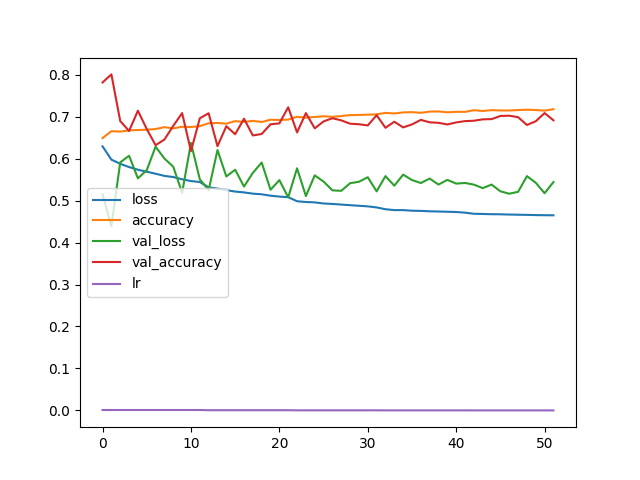

In [8]:
model_name = f"supervised_ep200_{model.name}"
model_save_dir = f"model/{model_name}/"
model_save_name = "model_{epoch:03d}_{loss:07.4f}_{val_loss:07.4f}"
csv_log_path = f"log/train.{model_name}.log.csv"

history = model.fit(
    data_X,
    data_y,
    validation_split=0.2,
    epochs=500,
    class_weight=class_weight,
    callbacks=[
        keras.callbacks.EarlyStopping(verbose=1, patience=50),  # 15
        keras.callbacks.ReduceLROnPlateau(
            # factor=0.5, patience=5, verbose=1, min_lr=5e-6),
            factor=0.5,
            patience=10,
            verbose=1,
            min_lr=5e-6,
        ),
        # factor=0.5, patience=15, verbose=1, min_lr=5e-6),
        keras.callbacks.CSVLogger(csv_log_path, append=True),
        keras.callbacks.ModelCheckpoint(
            model_save_dir + model_save_name, verbose=1, save_best_only=False
        ),
        keras.callbacks.TerminateOnNaN(),
    ],
)

import pickle

with open(f"log/train.{model_name}.history.pkl", "wb") as file:
    pickle.dump(history.history, file)

import pandas as pd
from matplotlib import pyplot as plt

pd.DataFrame(history.history).plot()  # figsize=(8,5))
# plt.grid(True)
# plt.gca().set_ylim(0,1)
plt.show()


### Run

In [3]:
import keras

# model = keras.models.load_model("model/supervised_mlp_input18_dense64relu3x_dense2softmax/model_018_00.4771_00.5215")
model = keras.models.load_model(
    "model/supervised_ep100_mlp_input18_dense64relu2x_dense2softmax/model_030_00.4889_00.4950"
)
model = keras.models.load_model(
    "model/supervised_ep200_mlp_input18_dense64relu2x_dense2softmax/model_022_00.5080_00.5078"
)

# model = keras.models.load_model(f"model/{model_name}/model_018_00.4771_00.5215")


In [62]:
import time

import requests


def get_status():
    return requests.get("http://localhost:9775/status").json()


def do_action():
    requests.get("http://localhost:9775/do")


def preprocess_data(game_status):  # v0 18 values hasSpike
    res = [
        game_status[i] for i in "charX charY charDir velocityY pinePos pineDir".split()
    ]
    res += game_status["hasSpike"]
    return np.array([res])


def preprocess_data(game_status):  # v0 18 values hasSpike
    res = [
        game_status[i] for i in "charX charY charDir velocityY pinePos pineDir".split()
    ]
    res += game_status["hasSpike"]
    res = np.array([res])
    return (res[:, :6], res[:, 6:][..., np.newaxis])


time.sleep(3)

for i in range(10):
    time.sleep(1)

    do_action()
    time.sleep(0.9)
    do_action()
    terminal = False
    while not terminal:
        time.sleep(0.05)
        stat = get_status()
        state = preprocess_data(stat["gameStatus"])
        terminal = not stat["playing"]
        act = np.argmax(model.predict(state)[0])
        # print(act, stat)
        if act == 1:
            do_action()


## Ray RLlib

### Train

In [2]:
%matplotlib widget


In [ ]:
import os
import csv
import json
import shutil

import ray
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
# from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn.dqn import DQNConfig
from ray.rllib.algorithms.callbacks import DefaultCallbacks

if not ray.is_initialized():
    print("init ray")
    ray.init()

# test_data = [None]
class MyCallbacks(DefaultCallbacks):
    ep_no = -1
    def on_episode_end(self, *, worker, base_env, policies, episode, env_index, **kwargs):
        # test_data[0] = [worker, base_env, policies, episode, env_index]
        # raise SystemExit
        self.ep_no += 1
        reward = episode.total_reward
        length = episode.length
        with open(csv_log_path, "a", newline="", encoding="utf-8-sig") as file:
            writer = csv.writer(file, delimiter=",")
            data = [self.ep_no, reward, length]
            writer.writerow(data)
        if self.ep_no % checkpoint_per_episodes == 0:
            algo.save(checkpoint_path)
            algo.export_policy_model(export_path % self.ep_no)

# ray_ddqn_fcnet64x2_m50k_b1_h25_d97_e0_lr001_n01
# ray_ddqn_fcnet64x2_m50k_b25_h25_d97_e0_lr001_n01
"""
config = (
    DQNConfig()
    .environment(env=DttsEnv)
    .framework("tf2")
    .rollouts(soft_horizon=25, batch_mode="complete_episodes")  # , rollout_fragment_length=1, )
    # .evaluation(evaluation_num_workers=1)
    .exploration(explore=False)
    .reporting(min_sample_timesteps_per_iteration=1)  # otherwise it'll collect 1000 steps for 1 train()
    # .checkpointing()
    # .debugging()  # logger
    .callbacks(MyCallbacks)
    .training(
        gamma=0.97,  # discount factor
        lr=1e-3,
        # train_batch_size=1,
        train_batch_size=25,
        model={"fcnet_hiddens": [64, 64]},

        noisy=True,
        sigma0=0.01,  # noise
        double_q=True,
        # n_step=25,
        # replay_buffer_config={ “_enable_replay_buffer_api”: True, “type”: “MultiAgentReplayBuffer”, “capacity”: 50000, “replay_sequence_length”: 1, }
        replay_buffer_config={"capacity": 50000},
    )
)
"""
# ray_rainbow_step10_atoms10
"""
config = (
    DQNConfig()
    .environment(env=DttsEnv)
    .framework("tf2")
    .rollouts(batch_mode="complete_episodes")
    .reporting(min_sample_timesteps_per_iteration=1)  # otherwise it'll collect 1000 steps for 1 train()
    .callbacks(MyCallbacks)
    .training(
        n_step=10,  # [between 1 and 10]
        noisy=True,
        num_atoms=10,  # [more than 1]
        v_min=-20, v_max=150,  # expected range of returns
    )
)
"""
# ray_rainbow_RollLen4_eTs2Final0_atoms51_noisy_d99_lr0001_fcnet256x1_b32_step3_UpFreq500_bufA5Cap50k
config = (
    DQNConfig()
    .environment(env=DttsEnv)
    .framework("tf2")
    .rollouts(rollout_fragment_length=4)
    # .reporting(min_sample_timesteps_per_iteration=1)  # otherwise it'll collect 1000 steps for 1 train()
    .callbacks(MyCallbacks)
    .exploration(exploration_config=dict(epsilon_timesteps=2, final_epsilon=0.0))
    .training(
        num_atoms=51,  # [more than 1]
        noisy=True,
        gamma=0.99,  # discount factor
        lr=1e-4,
        model={"fcnet_hiddens": [256]},
        train_batch_size=32,
        n_step=3,  # [between 1 and 10]
        target_network_update_freq=500, #
        replay_buffer_config=dict(
            type="MultiAgentPrioritizedReplayBuffer",
            prioritized_replay_alpha=0.5,
            capacity=50000
        ),
        num_steps_sampled_before_learning_starts=10000, #
    )
)
algo = config.build()

# model_name = "ray_ddqn_fcnet64x2_m50k_b1_h25_d97_e0_lr001_n01"  # 1 ep / 1 train()
# model_name = "ray_ddqn_fcnet64x2_m50k_b25_h25_d97_e0_lr001_n01"
# model_name = "ray_rainbow_step10_atoms10"
model_name = "ray_rainbow_RollLen4_eTs2Final0_atoms51_noisy_d99_lr0001_fcnet256x1_b32_step3_UpFreq500_bufA5Cap50k"
csv_log_path = f"log/train.{model_name}.csv"
checkpoint_path = f"model/{model_name}"
export_path = f"model/{model_name}/tf_%06d"

if os.path.exists(csv_log_path):
    print("File exists!")
    input("Press ENTER to delete!")
    if os.path.exists(checkpoint_path):
        shutil.rmtree(checkpoint_path)
with open(csv_log_path, "w", newline="", encoding="utf-8-sig") as file:
    writer = csv.writer(file, delimiter=",")
    writer.writerow(["episode", "return", "length"])

num_episodes = 5000
checkpoint_per_episodes = 50
pbar = tqdm(total=num_episodes)
while True:
    history = algo.train()
    if history["episodes_total"] >= num_episodes:
        break
    reward = history["hist_stats"]["episode_reward"][-1]
    length = history["hist_stats"]["episode_lengths"][-1]
    pbar.n = history["episodes_total"]
    pbar.desc = f"Iter {pbar.n}/{num_episodes} reward: {reward} length: {length}"
    pbar.update()
# ray.shutdown()

df = pd.read_csv(csv_log_path)
print(df["return"].describe())
# df["return"].plot()
ma_window = 500
(df["return"].rolling(ma_window).sum() / ma_window).plot()


In [4]:
history

{'custom_metrics': {},
 'episode_media': {},
 'info': {'learner': {},
  'num_env_steps_sampled': 4,
  'num_env_steps_trained': 0,
  'num_agent_steps_sampled': 4,
  'num_agent_steps_trained': 0},
 'sampler_results': {'episode_reward_max': nan,
  'episode_reward_min': nan,
  'episode_reward_mean': nan,
  'episode_len_mean': nan,
  'episode_media': {},
  'episodes_this_iter': 0,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [], 'episode_lengths': []},
  'sampler_perf': {},
  'num_faulty_episodes': 0},
 'episode_reward_max': nan,
 'episode_reward_min': nan,
 'episode_reward_mean': nan,
 'episode_len_mean': nan,
 'episodes_this_iter': 0,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'hist_stats': {'episode_reward': [], 'episode_lengths': []},
 'sampler_perf': {},
 'num_faulty_episodes': 0,
 'num_healthy_workers': 0,
 'num_in_flight_async_reqs': 0,
 'num_remote_wor

<AxesSubplot: >

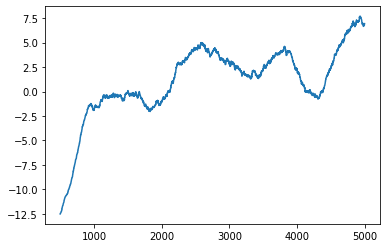

In [3]:
(df["return"].rolling(ma_window).sum() / ma_window).plot()


In [ ]:
%tensorboard --logdir=~/ray_results

In [34]:
ray.rllib.utils.check_env(DttsEnv({}))

In [ ]:
from ray.util import inspect_serializability
import threading

lock = threading.Lock()

def test():
    print(lock)

inspect_serializability(DttsEnv, name="test")

In [8]:
import ray
ray.is_initialized()

False

In [17]:
ray.shutdown()